# Apprentissage ensembliste et Forêts Aléatoires

Comme exemple d'EM, on peut entraîner un groupe de classificateurs DT, chacun sur un sous-ensemble aléatoire différent du JdE. Pour faire des prédictions, on prend les prédictions de chaque arbre, et on prédit la classe qui obtient le plus de vote. Cet ensemble de DT est appelé une RF, et en dépit de sa simplicité, c'est un des plus puissants algo de ML disponible aujourd'hui.

## Setup

In [3]:
#python >= 3.5 nécessaire
import sys
assert sys.version_info >= (3, 5)

#scikit-learn >= 0.20 nécessaire
import sklearn
assert sklearn.__version__ >= "0.20"

# Autres imports
import numpy as np
import os

# pour rendre les output stables au fil des runs
np.random.seed(42)

# pour tracer de jolis graphes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# où sauvegarder les figures
PROJECT_ROOT_DIR = ".."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Classificateurs de vote

Supposons qu'on a entraîné quelques que classificateurs, chacun atteignant 80% de précision. On peut avoir un classificateur de Régression Logistique, SVM, RF, KNN voire même quelques autres de plus.

![](fig1.png)

Une manière très simple de créer un meilleur classificateur est d'agréger les prédictions de chaque classificateur et de prédire la classe qui obtient le plus de votes. Ce vote classificateur de vote par majorité est appelé un classificateur *hard voting*.

![](fig2.png)

Quelque peu surprenant, ce classificateur de vote atteint souvent des précisions plis haute que le meilleur des classificateurs de l'ensemble. En fait, même si chaque classificateur est un apprenant faible (*weak learner*, il fait ne fait qu'un peu mieux qu'une supposition aléatoire), l'ensemble peu être un apprenant fort (*strong learner*, qui atteint une haute précision), à condition qu'ils soient en nombre suffisant et qu'ils soient assez diversifiés.

Comment est-ce possible ? L'analogie suivante peut aider à faire la muière sur ce mystère. Imaginons qu'on a une pièce légèrement biaisée qui a 51% de chance de faire face et 49% de chance de faire pile. Si on la jette mille fois, on devrait générallement obtenir plus ou moins 510 faces et 490 piles, et par conséquent, une majorité de faces. Si on fait le calcul, on trouvera que la probabilité d'obtenir une majorité de faces après 1000 essais est proche de 75%. Plus on effectue de lancers, plus la probabilité monte (97% à 10000). Ceci est dû à *loi des grands nombres* : tant qu'on continue à faire des lancers, le ration de faces devient de plus en plus proche de la probabilité de tirer face ($51%$).

La figure ci-dessous montre 10 séries de jeters de pièces biaisées. On peut voir qu'à mesure que le nombre de lancers augmente, le ratio "face" approche $51%$. À la fin, les 10 séries finissent si proches des $51%$ qu'elles sont au dessus de 50%.

In [4]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


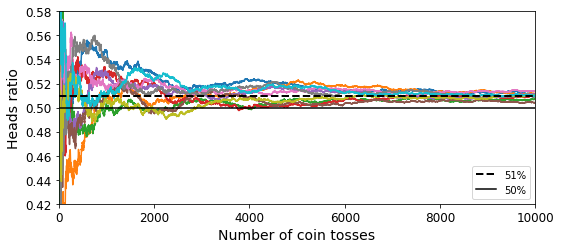

In [5]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

De manière similaire, supposons qu'on veuille construire un ensemble contenant 1000 classificateurs qui sont individuellement corrects 51% du temps (légèrement mieux qu'une supposition aléatoire). Si on prédit la classe votée majoritairement, on peut espérer atteindre 75% de précision.

Cependant, ceci est vrai seulement si tous les classificateurs sont parfaitement indépendants, faisant des erreurs non-correlées, ce qui n'est clairement pas le cas parce qu'ils sont entraînés sur les mêmes données. Ils auront tendance à faire les mêmes types d'erreurs, donc il y aura beaucoup de vote par majorité pour la mauvaise classe, réduisant la précision de l'ensemble.

*Remarque* : Les EM fonctionnent mieux quand les prédicteurs sont aussi indépendants les uns des autres que possible. Une manière d'avoir des classificateurs divers est de les entraîner en utilisant des algo très différents. Cela augmente les chances qu'ils feront des types d'erreurs très différents, améliorant la précision de l'ensemble.

Le code suivant crée et entraîne un classificateur de vote dans sklearn, cposé de trois classficiateurs différents (le JdE est le moons dataset) :


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Pour stabiliser le notebook à l'avenir, on va fixer `solver=lbfgs`, `n_estimators=100` et `gamma=scale`

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting="hard"
)

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Regardons la précision de chaque estimateurs sur le JdT :

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


On peut voir que le `VotingClassifier` a une performance légèrement meilleure que les autres.

Si tous les classificateurs sont capables d'estimer des probabilités de classe (cad, s'ils ont tous une méthode `predict_proba()`), alors on peut demander à sklearn de prédire la classe avec la plus haute probabilité de classe, moyenné sur tous les classificateurs individuels. C'est ce qu'on appelle le vote doux (*soft voting*).

Le vote doux atteint souvent de meilleures performances que le vote dur, parce qu'il donne plus de poids aux votes avec une haute confiance. Tout ce qu'on a besoin de faire est de remplacer `voting="hard"` par `voting="soft"` et de s'assurer que tous les classificateurs peuvent estimer des probabilité de classe.

Ceci n'est pas le cas pour la classe `SVC` par défaut, donc on a besoin de régler son hyperparamètre `probability` à `True` (cela va faire que la classe `SVC` va utiliser la validation croisée pour estimer les probabilités de classe, ralentissant l'entraînement, et ça ajoutera une méthode `predict_proba()`). Si on modifier le code précédent pour utiliser le vote doux, on trouvera que le classificateur dépasse les 91.2% de précision.

In [10]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [11]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## *Bagging* et *Pasting*

Un moyen d'avoir un ensemble de classificateurs diversifié est d'utiliser des algo d'entraînement très diversifiés.

Une autre approche est d'utiliser le même algo d'entraînement pour chaque prédicteur et de les entraînement sur différents sous-ensembles du JdE.

Quand l'échantillonnage est réalisé *avec remplacement*, cette méthode est appelé *bagging* (pour *bootstrap aggregating*).

Quand l'échantillonnage est réalisé *sans remplacement*, cette méthode est appelée *pasting*.

En d'autres termes, le bagging et le pasting permettent d'échantillonner plusieurs instances d'entraînement
plusieurs fois sur plusieurs prédicteurs, mais seul le bagging permet aux instances d'entraînement d'être échantilloné plusieurs fois pour le même prédicteur. Cet échantillonnage et ce processus d'entraînement est représenté sur la figure ci-dessous :

![Le bagging et le pasting implique l'entraînement de nombreux prédicteurs sur différents échantillons aléatoires du jeu d'entraînement](fig4.png)

Une fois que tous les prédicteurs sont entraînés, l'ensemble peu faire des prédictions pour un nouvelle instance par simple aggrégation des prédictions de tous les prédicteurs. La fonction d'agrégation est typiquement le *mode statistique* (cad la plus fréquente prédiction, comme pour un classificateur vote dur), ou la moyenne de la régression. Chaque prédicateur a individuellement un plus ahute bias que s'il était entrapiné sur le JdE originel, mais l'agrégation réduit à la fois le biais et la variance. En génréal, le résultat net est que l'ensemble a un biais similaire mais une variance plus bas qu'un simple prédicteur entraîné sur le JdE originel.

Comme on peut le voir sur la dernière figure, les prédicteurs peuvent tous être entraînés en parallèle, via les différents cœurs du CPU ou même différents serveurs. Les prédictions peuvent également être faites en parallèle. C'est l'une des raisons pour laquelle le bagging et le plasting sont des méthodes aussi populaires : elle s'adaptent très bien. 

### Bagging et Pasting dans sklearn

sklearn fournit une API simple aussi bien pour le bagging que pour la psting, avec la classe `BaggingClassifier` (ou `BaggingRegressor` pour la régression). Le code suivant entraîne un ensemble de 500 classificateurs DT :

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [14]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


*Remarque* : le `BaggingClassifier` réalise automatique un vote doux plutôt qu'un dur si le classificateur de base peut estimer la probablité de classe (cad s'il a une méthode `predict_proba()`), ce qui est le cas avec les classificateurs des DT.

La figure suivante compare les limites de décision d'un simple DT avec la limite de décision d'un ensemble bagging de 500 arbres (du code précedent), les deux entraînés sur le moons dataset.

In [15]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


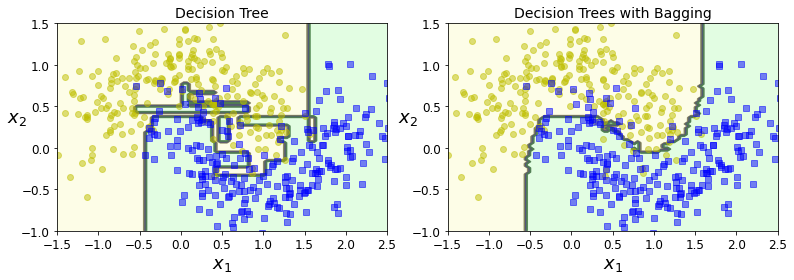

In [16]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Comme on peut le voir, les prédictions de l'ensemble vont beaucoup mieux généraliser que le simple DT : l'ensemble a un biais comparable mais une variance plus petite (elle fait à peu près le même nombre d'erreurs sur le JdE, mais la limite de décision est moins irrégulière).

Le bootstrapping introduit un peu plus de diversité dans les sous-ensembles sur lesquels chaque prédicteur est formé, donc le bagging fini avec un biais légèrement plus haut que le pasting; mais la diversité supplémentaire veut également dire que les prédciteurs finiront par être moins corrélés, donc la vbariance de l'ensemble est réduite. 

Globalement, le bagging résulte souvent en de meilleurs modèles, ce qui explique pourquoi il est plus généralement préféré. Cependant, si on a du temps et un CPU puissant, on peut utiliser la validation croisée pour évaluer à la fois le bagging et le pasting, et sélectionner celui qui fonctionne le mieux.

### Évalutation out-of-bag

Avec le bagging, certaines instances peuvent être échantillonnées plusieurs fois pour n'importe quel prédicteur donné, alors que d'autres ne seront pas échantillonnées du tout. Par défaut, `BaggingClassifier` échantillonne $m$ instances d'entraînement avec remplacement (`bootstrap=True`), où $m$ est la taille du JdE. Cela veut dire que seulement 63% des instances d'entraînement sont échantillonnées en moyenne pour chaque prédicteur. Les 37% restantes ne sont pas échantillonnées et sont appelées des instances *out-of-bag* (*oob*). À noter qu'elles ne sont pas le même 37% pour chaque prédicteur.

Puisqu'un prédicteur ne voit jamais les instances oob pendant son entraînement, il peut être évalué sur ces instances, sans avoir besoin d'un JdV séparé. On peut évaluer l'ensemble lui-même en faisant la moyenne des évaluations oob de chaque prédicteur.

Dans sklearn, on peut définir `oob_score=True` quand on crée un `BaggingClassifier` pour demander une évalution oob automatique après l'entraînement. Le code suivant démontre cela. Le score d'évalutation résultant est disponibe au travers de la variable `oob_score_` :

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    random_state=40
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

D'après cette observation oob, ce `BaggingClassifier` est susceptible d'atteindre 89.9% de précision sur le JdT ; vérifions :

In [18]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

On obtient 91.2% de précision sur le JdT.

La fonction de décision oob pour chaque instance d'entraînement est également disponible via la variable `oob_decision_function_`. Dans ce cas (puisque l'estimateur de base a une méthode `predict_proba`), la fonction de décision retourne les probabilité de classe pour chaque instance d'entraînement. Par exemple, l'évaluation oob estime que la première instance d'entraînement a 67.7% de chance d'appartenir à la classe positive (et 32.3% de chance d'appartenir à la classe négative).

In [19]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## Patches Aléatoires et Sous-Espaces Aléatoires (*Random Patches and Random Subspaces*)

La classe `BaggingClassifier` supporte aussi l'échantillonnage des features. L'échantillonnage (*sampling*) est contrôlé par deux hyperparamètres : `max_features` et `bootstratp_features`. Ils fonctionnent de la même manière que `max_samples` et `bootstrap`, mais pour des features plutôt que pour l'échnatillonnage d'instances. Ainsi, chaque prédicteur sera entraîné sur un sous-ensemble aléatoire des features d'entrée.

Cette technique est particulièrement utile quand on à affaire à des entrées de grande dimensions (comme les images). Échantillonner à la fois les instances d'entraînement et les features est appelé *méthode des patches aléatoires* (*[Random patches](https://www.semanticscholar.org/paper/Ensembles-on-Random-Patches-Louppe-Geurts/f5ae0b1b48a21ae9083f670d7043495f067064e4?p2df)*. Garder toutes les instances d'entraînement (en règlant `bootstrap=False` et `max_samples=1.0`) mais échantillonner les features (`bootstrap_features=True` et/ou `max_features` $<1$) est appelé *méthode des sous-espaces aléatoires* '(*[Random subspaces](https://www.researchgate.net/publication/3192880_The_Random_Subspace_Method_for_Constructing_Decision_Forests))*).

Échantilloner les features résulte en encore plus de diversité des prédicteurs, échangeant un peu plus de biais pour une variancve plus basse.

## Random Forest

La RF est un ensemble de DT, généralement entraîné avec la méthode bagging (parfois pasting), typiquement avec `max_samples` réglé sur la taille du JdT. Au  lieu de constuire un `BaggingClassifier` et de lui passer un `DecisionTreeClassfier`, on peut à la place utiliser la classe `RandomForestClassifier`, qui est plus pratique et optimisée pour les DT (il existe aussi une classe `RandomForestRegressor` pour les tâches de régression).

Le code suivant utilise tous les cœurs disponibles du CPU pour entraîner un classificateur RF avec 500 arbres (chaqun limité à 16  nœuds) :

In [20]:
# En passant par le BaggingClassifier et en utilisant le DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

In [21]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [22]:
# En passant directement par RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [23]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

À quelques exceptions, un `RandomForestClassifier` a tous les hyperparamètres d'un `DecisionTreeClassifier` (pour contrôler comment les arbres poussent), plus tous les hyperparamètres d'un `BaggingClassifier` pour contrôler l'ensemble lui-même.

L'algorithme RF introduit des hasards supplémentaires quand il fait pousser des arbres ; au lieu de chercher pour la meilleure feature quand il divise un nœud, il va chercher la meilleure feature parmis un sous-ensemble aléatoire de features. L'algo résulte en une plus grande diversité d'arbres, qui (à nouveau), augmente le biais pour réduire la variance, donnant généralement un meilleur modèle global.

### Arbres supplémentaires

Quand on fait pousser un arbre dans une RF, il n'y a, à chaque nœud, qu'un seul sous-ensemble de feature qui est considéré pour la division. Il est possible de rendre les arbres encore plus aléatoires en utilsant également des seuils aléatoires pour chaque feature, plutôt qu'en cherchant le meilleur seuil possible, comme les DT ordinaires font.

Une forêt d'arbres extrêments aléatoires est appelée *Extremely Randomized Tree Ensemble*, ou *Extra-Tree* pour faire court. Une fois encore, cette technique échange plus de biais pour une variance plus faible. Cela rend les Extra-Trees beaucoup plus rapide à entraîner que les RF ordinaires, parce trouver les meilleurs seuils possibles pour chaque feature à chaque nœud une des tâches qui consomme le plus de temps pour faire pousser un arbre.

On peut créer un classificateur Extra-Tree en utilisant la classe sklearn `ExtraTreesClassifier`. Son API est identique à celle de la classe `RandomForestClassifier`. On a également `ExtraTreeesRegressor` qui a la même API que `RandomForestRegressor`.

Remarque : il est dur de dire en avance si un `RandomForestClassifier` va avoir de meilleures ou pires performances qu'un `ExtraTreeesRegressor`. Généralement, la seule manière de le savoir est d'essayer les deux et de les comparer en utilisant la validation croisée (en réglant les paramètres en utilisant la grid search).

### L'importance des feature

Une autre grande qualité des RF est qu'elles permettent de mesurer facilement l'importance relative de chaque feature. sklearn mesure l'importance d'une feature en regardant combien les nœuds d'un arbre qui utilisent cette feature réduisent l'impureté en moyenne (à travers tous les arbres de la forêt). Plus précisément, c'est une pondération moyenne, où chaque poids d'un nœud est égal au nombre d'échantillons d'entraînement qui lui sont associés.

sklearn calcule ce score automatiquement pour chaque feautre après l'entraînement, puis met à l'échelle les résultats pour que la somme de toutes les importances soit égale à 1. On peut accéder au résultat en utilisant la variable `feature_importance_`. Par exemple, le code suivant contient un `RandomForestClassifer` sur le dataset de l'iris et sors l'importance de chaque feature. Il semble que les feature les plus importantes soient la longueur des pétales (44%) et leur largeur (42%),  tandis que la longeur et la largeur des sépales ont l'air sans importance en comparaison (11% et 2% respectivement).

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [25]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

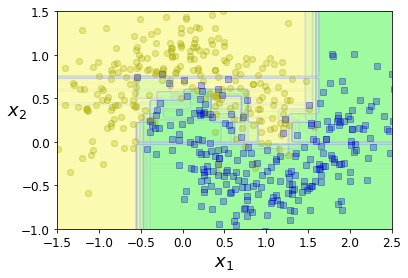

In [26]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

De la même manière, si on entraîne un classificateur RF sur le dataset MNIST et qu'on trace l'importance de chaque pixel, on obtient l'image suivante :

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [29]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


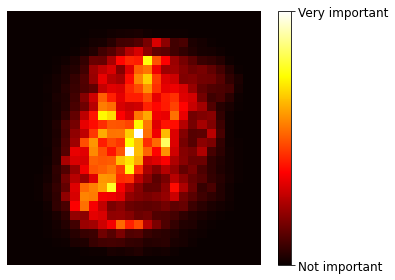

In [30]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting

Le *boosting* (à l'origine : *hypothesis boosting*) fait référence à toute méthode ensembliste qui peut combiner plusieurs apprenants faibles (*weak learner*) en un apprenant fort (*strong learner*). L'idée générale de la plupart des méthodes de boosting est d'entraîner les prédicteurs séquentiellement, chacun essayant de corriger son prédécesseur.

Il y a plusieurs méthodes de bossting disponibles, mais la plus populaire est de loin l'*Adaboost* (pour *adaptative boosting*) et les *Gradient Boosting*.


### Adaboost

Une manière pour un nouveau prédicteur de corriger son prédécesseur est de faire un peu plus attention aux instances d'entraînement que son prédécesseur a underfit. Cela résulte en une novuelle prédiction focalisant de plus en plus sur les cas difficiles. C'est la technique utilisée en adaboost.

Par exemple, quand on entraîne un classificateur adaboost, l'algo entraîne d'abord un classificateur de base (comme un DT), et l'utilise pour faire des prédictions sur le JdE. L'algo augmente ensuite le poids relatif des instances d'entraînement mal classées. Puis, il entraîne un autre classificateur, utilisant les poids mis-à-jour, et va à nouveau faire des prédictions sur le JdE, mettre à jour les poids des instances, et ainsi de suite.

![](fig7.png)

La figure suivante montre les limites de décision de 5 prédicteurs consécutifs sur le dataset moons (dans cet exemple, chaque prédicteur est un classificateur SVM hautement régularisé avec un kernel RBF ; c'est seulement pour l'illustration, les SVM sont en général de mauvais prédicteurs pour l'adaboost, ils sont lents et ont tendance a être instable avec).

In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)

ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

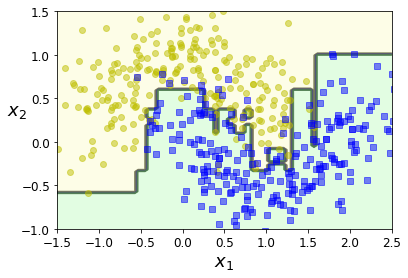

In [32]:
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


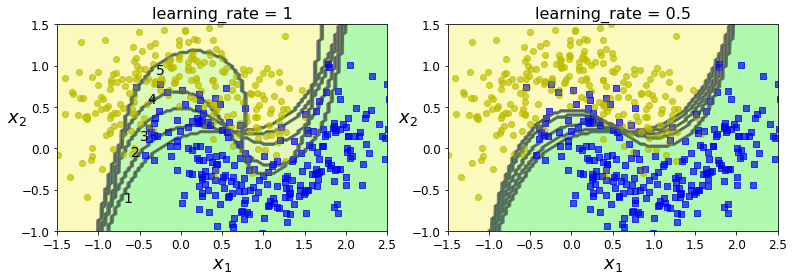

In [33]:
m = len(X_train)


plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

In [34]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_',
 'n_features_in_']

Une fois que tous les prédicteurs sont entraînés, l'ensemble rend les prédictions très similaires au bagging/pasting, à part que les prédicteurs ont des poids différents en fonction de leur précision générale sur le JdE pondéré.

*Attention* : il un inconvénient majeur à cette technique d'apprentissage séquentielle : elle ne peut pas être parallelisée (ou alors seulement partiellement), puisque chaque predicteur peut seulement être entraîné après que le précédent a été entraîné et évalué.

Regardons l'algo Adaboost. Chaque poids d'instance $w^{(i)}$ est initiallement fixé à $1/m$. Un premier prédicteur est entraîné, et son taux d'erreur pondéré $r_1$ est calculé sur le JdE.


*Taux d'erreur pondéré du j-ème prédicteur*
$$
\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\space\sum_{i=1}^mw^{(i)}
$$
$$
r_j=\frac{\hat{y}_{j}^{(i)}\neq y{i}}{\sum_{i=1}^mw^{(i)}}
$$

où $\hat{y}_{j}^{(i)}$ est la j-ème prédiction du prédicteur pour l'i-ème instance.


Le poids du prédicteur $\alpha_j$ est ensuite calculé selon l'équation suivante, où $\eta$ est l'hyperparamètre du taux d'apprentissage (défaut à 1 ; l'algo adaboost original n'utilise pas cet hyperparamètre). Plus le prédicteur sera précis, plus son poids sera élevé. S'il est seulement en train de deviner de manière aléatoire, alors sont poids sera proche de zéro. Cependant, s'il est le plus souvent erroné (cad moins précis qu'une suppostion aléatoire), alors son poids sera négatif.


*Poids du prédicteur*
$$
\alpha_j = \eta\log\frac{1-r_j}{r_j}
$$

Ensuite, l'algo Adaboost met à jour les poids des instances, utilisant l'équation suivante qui boost le poids des instances mal classées.

*Règle d'actualisation du poids*
$$
\text{pour}\space i = 1, 2, \cdots, m
$$
$$
w^{(i)} \leftarrow
\begin{cases}
  w^{(i)} & \text{si}\space {\hat{y_{j}}}^{(i)} = y^{(i)} \\
  w^{(i)}\exp(\alpha_j) & \text{si}\space \hat{y}^{(i)} \neq y^{(i)} \\
  \end{cases}
$$

Puis, tous les poids des instances sont normalisés (cad divisés par $\sum_{i=1}^mw^{(i)}$).

Enfin, un nouveau prédicteur est entraîné en utilisant les poids actualisés, et tout le processus est répété (le nouveau poids du prédicteur est calculé, les poids des instances actualisés, et un autre prédicteur est entraîné, et ainsi de suite). L'algo s'arrête quand le nombre voulu de prédicteurs est atteint, ou quand un prédicteur parfait est trouvé.

Pour faire des prédictions, AdaBost valcule simplement les prédictions de tous les prédicteurs et les pondère en utilisant le poids de prédicteur $\alpha_j$. La classe prédite est celle qui reçoit la majorité des votes pondérés.

*Prédictions AdaBoost*

$$
\hat{y}(\text{x}) = \argmax_k{\sum_{j=1}^N}_{\hat{y}(\text{x}) = k}\alpha_j \space\text{où}\space N\text{est le nombre de prédicteurs}
$$

sklearn utilise une version multiclasse de l'AdaBoost appelé [SAMME](https://www.intlpress.com/site/pub/pages/journals/items/sii/content/vols/0002/0003/a008/) (pour *Stagewise Additive Modeling using a Multiclass Exponention loss function). Quand il y a seulement deux classe, SAMME est équivalent à l'AdaBoost. Si les prédiceurs peuvent estimer les probabilités des classes (cad s'ils ont une méthode `predict_proba()`), sklearn peut utiliser une variante appelée SAMME.R (R pour *Real*), qui repose sur les probabilités de classe plutôt que sur les prédictions, et qui a en général de meilleurs performances.

Le code suivant entraîne un classificateur AdaBoost basé sur 200 *Decision Stumps* en utilisant la classe sklearn `AdaBoostClassifier` (comme on peut s'en douter, il n'existe pas de classe AdaBoostRegressor). Une Decision Stump est un DT avec `max_depth=1` ; en d'autres termes, c'est un arbre composé d'un seul nœud de décision et de deu feuilles. C'est l'estimateur de base par défaut de la classe `AdaBoostClassifier` : 

In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

*Remarque* : Si notre ensemble AdaBoost overfit le JdE, on peut essayer de réduire le nombre d'estimateurs ou régulariser plus fortement l'estimateur de base.

### Gradient Boosting

Un autre algorithme de boosting très populaire est le *Gradient Boosting* (GB). Comme l'AdaBoost, le GB fonctionnent en ajoutant séquentiellement des prédicteurs à son ensemble, chacun corrigeant son prédécesseur. Cependant, au lieu de modifier les poids des instances à chaque itération comme le fait l'AdaBoost, cette méthode essaie d'ajuster le nouveau prédicteur aux *erreurs résiduelles* faites par le prédicteur précédent.

Passons au travers d'un exemple simple de régression, en utilisant un DT comme prédicteur de base (bien sûr, le GB fonctionne très bien avec les tâches de régressions). C'est ce qu'on appelle *Gradient Tree Boosting* ou *Gradient Boosted Regression Tree* (GBRT). D'abord, adaptons un DT au JDE (quadratique avec du bruit) :

In [37]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Ensuite, on entraîne un second `DecisionTreeRegressor` sur les erreurs résiduelles faites par le premier prédicteur :

In [39]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Ensuite, on entraîne un troisième régresseur sur les erreurs résiduelles faites par le second prédicteur :

In [40]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

On a maintenant un ensemble contenant trois arbres. Il peut faire des prédictions sur une nouvelle instance simplement en ajoutant une prédiction aux trois arbres:

In [42]:
X_new = np.array([[0.8]])

In [44]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [45]:
y_pred

array([0.75026781])

La figure suivante représente les prédictions de ces trois arbres dans la colonne de gauche, et les prédictions de l'ensemble dans la colonne de droite. Dans la première ligne, l'ensemble a un seul arbre, donc ses prédictions sont exacelement les mêmes que celles du premier arbre. Dans la deuxième ligne, un nouvel arbre est entraîné sur les erreurs résiduelles faites par le premier arbre. Sur la droite, on peut voir que les prédictions de l'ensemble sont égales à la somme des prédictions des deux premiers arbres. De la même manière, dans la dernière ligne, un autre arbre est entraîné sur les erreurs résiduelles du deuxième arbre. On peut voir que les prédictions de l'ensemble devienne meilleures à mesure que les arbres sont ajoutés.

Saving figure gradient_boosting_plot


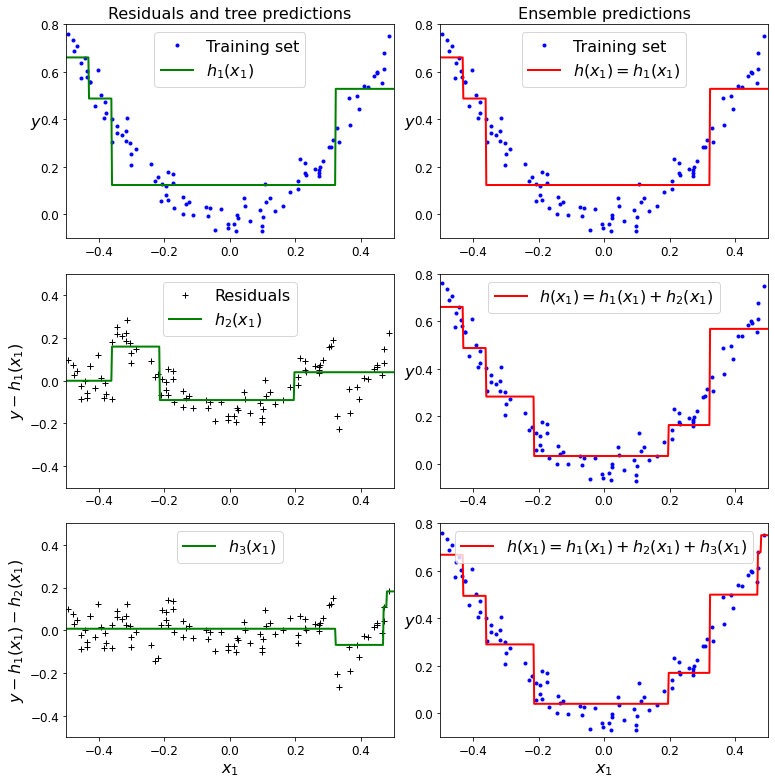

In [46]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

Une manière plus simple d'entraîner un ensemble GBRT est d'utiliser la classe sklearn `GradientBosstingRegressor`. Tout comme la classe `RandomForestRegressor`, il a des hyperparamètres pour contrôler la croissance des DT (`max_depth`, `min_sample_leaf`), ainsi que des hyperparamètres pour contrôler l'entraînement de l'ensemble, comme le nombre d'arbres (`n_estimators`). Le code suivant crée le même ensemble que ce qu'on a fait précédemment :

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

L'hyperparamètre `learning_rate` met à l'échelle la contribution de chaque arbre. Si on le règle à une valeur basse, comme 0.1, on va avoir besoin de plus d'arbres dans l'ensemble pour adapter le JdE, mais les prédictions généraliseront mieux, en règle générale. C'est une technique de régularisation appelée *shrinkage*. 

La figure suivante montre deux ensembles GBRT entraînés avec un faible taux d'apprentissage : celui sur la gauche n'a pas assez d'arbres pour adapter le JdE, tandis que celui sur la droite a trop d'arbres et overfit le JdE.

In [49]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


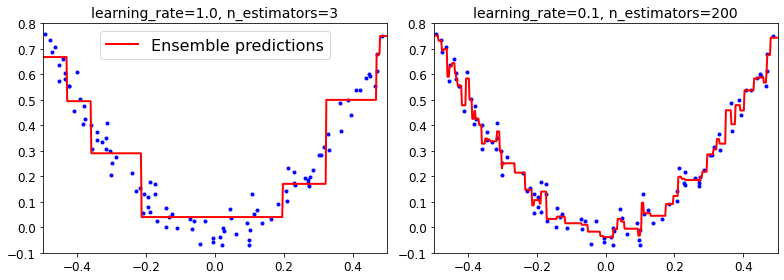

In [50]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

Afin de trouver le nombre optimal d'arbres, on peut utiliser l'arrêt précoce (Ch.4).

Une manière simple d'implémenter cela est d'utiliser la méthode `staged_predict()` : elle retourne un itérateur sur les prédictions faites par l'ensemble à chaque étape de l'entraînement (avec un, deux, trois arbres, etc.).

Le code suivant entraîne un ensemble GBRT avec 120 arbres, puis mesure l'erreur de validation à chaque étape d'entraînement pour trouver le nombre optimal d'arbres, pour enfin entraîner un autre ensemble GBRT en utilisant le nombre optimal d'arbres :

In [53]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [
    mean_squared_error(y_val, y_pred)
    for y_pred in gbrt.staged_predict(X_val)
]

bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=79, random_state=42)

Les erreurs de prédictions sont représentées sur la gauche de la figure suivante, et les prédictions du meilleur modèle sont représentées sur la droite.

In [56]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


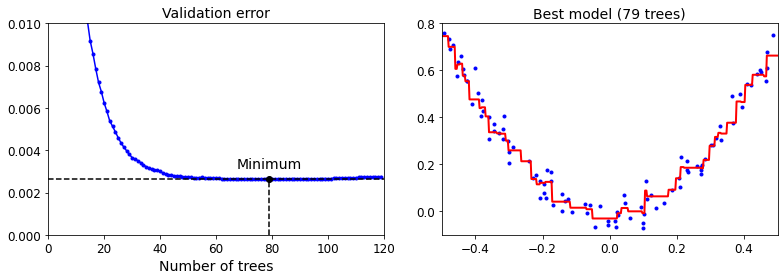

In [57]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

Il est également possible d'implémenter un arrêt précoce en arrêtant en fait l'entraînement tôt (au mie de le laisser s'entraîner sur un grand nombre d'arbres d'abord et d'ensuite regarder en arrière pour trouver le nombre optimal).

On peut faire cela avec `warm_start=True`, qui va faire en sorte que sklearn garde les arbres existant quand la méthode `fit()` est appelée, permettant un entraînement incrémentiel.

Le code suivant arrête l'entraînement quand l'erreur de validation ne s'améliore pas pour plus de 5 itérations à la suite :

In [58]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up+=1
        if error_going_up == 5:
            break # arrêt précoce

In [59]:
print(gbrt.n_estimators)

59


In [60]:
print("Minimum validation MSE :", min_val_error)

Minimum validation MSE : 0.0026930464329994377


La classe `GradientBoostRegressor` peut également prendre en charge un hyperparamètre `subsample`, qui spécifie la fraction des instances d'entraînement à utiliser pour entraîner chaque arbre. Par exemple, si `subsample=0.25`, alors chaque arbre est entraîné sur 25% des instances d'entraînement, sélectionnées aléatoirement.

Cette technique augmente le biais pour diminuer la variance. Elle accélère aussi considérablement le temps d'entraînement. Elle est appelée *Stochastic Gradient Boosting*.

*Remarque* : Il est possible d'utiliser le GB avec d'autres fonctions de coût. Cette option est contrôlée par l'hyperparamètre `loss` (cf doc sklearn).

Il convient de noter qu'une implémentation optimisée de Gradient Boosting est disponible dans la bibliothèque Python populaire XGBoost (Extreme Gradient Boosting). L'API d'XGBoost est assez similaire à celle de sklearn :

In [62]:
try:
    import xgboost
except ImportError as ex:
    print("Error : the xgboost library is not installed")
    xgboost = None

In [63]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.0032701197793426123


XGBoost offre également plusieurs options intéressantes, comme la prise en charge automatique de l'arrêt précoce :

In [64]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[0]	validation_0-rmse:0.21512
[1]	validation_0-rmse:0.16304
[2]	validation_0-rmse:0.12217
[3]	validation_0-rmse:0.09683
[4]	validation_0-rmse:0.08110
[5]	validation_0-rmse:0.06992
[6]	validation_0-rmse:0.06311
[7]	validation_0-rmse:0.05919
[8]	validation_0-rmse:0.05735
[9]	validation_0-rmse:0.05613
[10]	validation_0-rmse:0.05612
[11]	validation_0-rmse:0.05593
[12]	validation_0-rmse:0.05599
Validation MSE: 0.003127625770568247


In [65]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

24.7 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [66]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

8.32 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Stacking

La dernière méthode ensembliste qu'on va voir ici est appelée *stacking* (pour *stacked generalization*). Le stacking est basé sur une idée simple : au lieu d'utiliser des fonctions triviales (comme le vote dur) pour aggréger les prédictions de tous les prédicteurs en un ensemble, pourquoi n'entraîne-t-on pas un modèle pour réaliser cette aggrégation ?

La figure suivante montre un tel ensemble réalisant une tâche de régression sur une nouvelle instance. Chacun des trois prédicteurs en bas prédisent une valeur différente, et ensuite le prédicteur final (appelé un *blender* ou *meta learner*) prend ces prédictions en entrée et fait la prédiction finale.

![](fig12.png)

Pour entraîner le blender, une approche commune est d'utiliser un set hold-out. Regardons comment cela fonctionne. D'abord, le JdE est divisé en deux sous-ensembles. Le premier est utilisé pour entraîner les prédicteurs dans la première couche.

![](fig13.png)

Ensuite, les prédicteurs de la première couche sont utilisés pour faire des prédictions sur le deuxième set (hold out). Cela permet d'assurer que les prédicteurs sont "propres", puisque les prédicteurs n'ont jamais vu ces instances pendant l'entraînement. Pour chaque instance dans le set hold-out, il y a trois valeurs prédites. On peut créer un nouveau JdE en utilisant ces valeurs prédites comme features d'entrée. Le blender est entraîné sur ce nouveau JdE, pour qu'il apprenne à prédire les valeurs cibles, étant données les prédictions de la première couche.

![](fig14.png)

Il est en fait possible d'entraîner plusieurs nombreux blender de cette manière (par exemple en utilisant la régression linéaire, un autre en utilisant la Random Forest Regression), pour obtenir une couche entière de blenders. 

L'astuce est de diviser le JdE en trois sous-ensembles : le premier est utilisé pour entraîner la première couche, le deuxième pour créer le JdE utilisé pour la seconde couche (en utilisant les prédictions faites par les prédicteurs de la première couche), et le troisième est utilisé pour créer un JdE pour entraîner la trosième couche (en utilisant les prédictions faites par les prédicteurs de la deuxième couche).

Une fois cela fait, on peut faire une prédiction pour une nouvelle instance en passant par chaque couche séquentiellement, comme présenté ci-dessous :

![](fig15.png)

Malheureusement, sklearn ne prend pas en charge le stacking directement, mais ce n'est pas trop difficile de réaliser sa propre implémentation (voir les exercices). Il est également possible d'utiliser une implémentation open source comme `DESlib`.

# Exercices

(à compléter)